In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-02-12 18:49:19.153106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 18:49:19.153207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 18:49:19.303786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab  

In [5]:
vocab=np.unique(get_vocab())

In [6]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [8]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [9]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [10]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

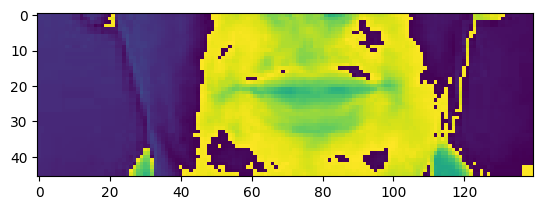

In [11]:
plt.imshow(frames[40])

In [12]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [13]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [14]:
frames, alighnments = data.as_numpy_iterator().next()

In [15]:
sample = data.as_numpy_iterator()

In [16]:
val = sample.next();val[0]

array([[[[[1.5897197 ],
          [1.5897197 ],
          [1.2869159 ],
          ...,
          [0.34065422],
          [0.30280375],
          [0.30280375]],

         [[1.5140188 ],
          [1.5518693 ],
          [1.135514  ],
          ...,
          [0.34065422],
          [0.30280375],
          [0.30280375]],

         [[1.5897197 ],
          [1.5897197 ],
          [1.5140188 ],
          ...,
          [0.3785047 ],
          [0.30280375],
          [0.30280375]],

         ...,

         [[1.0598131 ],
          [1.0598131 ],
          [1.0598131 ],
          ...,
          [0.11355141],
          [0.11355141],
          [0.07570094]],

         [[1.0598131 ],
          [1.0598131 ],
          [1.0598131 ],
          ...,
          [0.11355141],
          [0.07570094],
          [0.07570094]],

         [[1.0598131 ],
          [1.0598131 ],
          [1.0598131 ],
          ...,
          [0.07570094],
          [0.07570094],
          [0.03785047]]],


        [[[1.4761

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [18]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [19]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [20]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [21]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [22]:
# checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
# schedule_callback = LearningRateScheduler(scheduler)
# example_callback = ProduceExample(test)

In [23]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [24]:
# model.fit(train,validation_data=test,epochs=1,callbacks=[checkpoint_callback,schedule_callback,example_callback])

In [25]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# # Load data from the file path
# frames, alignments = load_data(tf.convert_to_tensor(path))

# # Ensure the data matches the expected input shape
# frames = tf.reshape(frames, (1, 75, 46, 140, 1))

# # Predict using the model
# predictions = model.predict(frames)


In [26]:
# class AccuracyMetrics(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.predictions = []
#         self.ground_truth = []

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
#         self.predictions.extend(decoded)
#         self.ground_truth.extend(data[1])

# # ... (your previous code)

# accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

# model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# # After training, compute accuracy or any other metric using predictions and ground truth
# predictions = accuracy_metrics.predictions
# ground_truth = accuracy_metrics.ground_truth

# # Compute accuracy (or any other suitable metric) here
# # For example, using sequence_accuracy from Levenshtein distance:
# from nltk.metrics.distance import edit_distance

# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# accuracy = compute_accuracy(predictions, ground_truth)
# print("Accuracy:", accuracy)


In [27]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)

# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=51, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


In [28]:
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     total_samples = len(preds)
#     correct_samples = sum(1 for pred, truth in zip(preds, truths) if pred == truth)
#     accuracy = correct_samples / total_samples
#     return accuracy

In [29]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, training_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.training_data = training_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []
#         self.training_accuracies = []  # Nouvelle liste pour l'accuracy d'entraînement
#         self.training_losses = []      # Nouvelle liste pour la perte d'entraînement

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

#         # Training Accuracy and Loss
#         training_data = next(self.training_data)
#         training_predictions = self.model.predict(training_data[0])
#         training_decoded = tf.keras.backend.ctc_decode(training_predictions, [75, 75], greedy=False)[0][0].numpy()
#         training_ground_truth = training_data[1]

#         training_accuracy = compute_accuracy(training_decoded, training_ground_truth)
#         training_loss = self.model.evaluate(training_data[0], training_data[1], verbose=0)

#         print(f'Training Accuracy at epoch {epoch + 1}: {training_accuracy }')
#         print(f'Training Loss at epoch {epoch + 1}: {training_loss}')

#         self.training_accuracies.append(training_accuracy)
#         self.training_losses.append(training_loss)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return (1 - acc)

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# # model.compile(optimizer='adam', loss=CTCLoss)
# # accuracy_callback = AccuracyCallback(validation_data=test_data, training_data=train_data)  # Utiliser l'ensemble de test et d'entraînement

# # history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # # Plotter les courbes d'accuracy
# # plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# # plt.plot(accuracy_callback.training_accuracies, label='Training Accuracy')  # Nouvelle courbe pour l'accuracy d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Accuracy')
# # plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# # plt.legend()
# # plt.show()

# # # Plotter les courbes de perte
# # plt.plot(history.history['loss'], label='Training Loss')  # Utilise les informations de history pour la perte d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Perte')
# # plt.title('Évolution de la perte d\'entraînement pendant l\'entraînement')
# # plt.legend()
# # plt.show()
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()

In [30]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy lettre par lettre
# def compute_accuracy_letter_by_letter(preds, truths):
#     total_letters = 0
#     correct_letters = 0

#     for pred, truth in zip(preds, truths):
#         for p, t in zip(pred, truth):
#             total_letters += 1
#             if p == t:
#                 correct_letters += 1

#     accuracy = correct_letters / total_letters if total_letters > 0 else 0
#     return accuracy

# # Chargement des données (assurez-vous de définir la fonction mappable_function)
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)  # Assurez-vous de remplacer 'ctc_loss_function' par votre fonction CTCLoss
# accuracy_callback = AccuracyCallback(validation_data=test_data)

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


Epoch 1/50


I0000 00:00:1707763794.173044      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/225 [============================>.] - ETA: 1s - loss: 83.1880

[mpeg1video @ 0x7e0c6c059b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6c059b00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 83.1377

[mpeg1video @ 0x7e0dd016b240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dd016b240] Warning MVs not available
[mpeg1video @ 0x7e0864235840] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0864235840] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Validation Accuracy at epoch 1: 7.50%
225/225 [==============================] - 539s 2s/step - loss: 83.1377 - val_loss: 73.1525
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 71.9302

[mpeg1video @ 0x7e085c071900] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c071900] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Validation Accuracy at epoch 2: 6.25%
225/225 [==============================] - 406s 2s/step - loss: 71.9302 - val_loss: 69.0609
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 68.6540

[mpeg1video @ 0x7e0db8022a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0db8022a80] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 3: 5.00%
225/225 [==============================] - 409s 2s/step - loss: 68.6540 - val_loss: 63.6387
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 64.8720

[mpeg1video @ 0x7e0cc8012840] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cc8012840] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Validation Accuracy at epoch 4: 10.00%
225/225 [==============================] - 404s 2s/step - loss: 64.8720 - val_loss: 61.4391
Epoch 5/50
199/225 [=========================>....] - ETA: 18s - loss: 62.8495

[mpeg1video @ 0x7e0848050f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0848050f00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 62.8468

[mpeg1video @ 0x7e0c64a11bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c64a11bc0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Validation Accuracy at epoch 5: 2.50%
225/225 [==============================] - 406s 2s/step - loss: 62.8468 - val_loss: 58.1474
Epoch 6/50
198/225 [=========================>....] - ETA: 19s - loss: 60.6605

[mpeg1video @ 0x7e0db0055cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0db0055cc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 60.2452

[mpeg1video @ 0x7e084c08bd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e084c08bd40] Warning MVs not available


1/1 [==============================] - 0s 130ms/step
Validation Accuracy at epoch 6: 8.75%
225/225 [==============================] - 401s 2s/step - loss: 60.2452 - val_loss: 53.5935
Epoch 7/50
 65/225 [=======>......................] - ETA: 1:52 - loss: 55.5667

[mpeg1video @ 0x7e0c940c9b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c940c9b80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 55.4387

[mpeg1video @ 0x7e0dc40636c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc40636c0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 7: 3.75%
225/225 [==============================] - 400s 2s/step - loss: 55.4387 - val_loss: 51.6647
Epoch 8/50
225/225 [==============================] - ETA: 0s - loss: 53.4453

[mpeg1video @ 0x7e0cc805a600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cc805a600] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Validation Accuracy at epoch 8: 0.00%
225/225 [==============================] - 412s 2s/step - loss: 53.4453 - val_loss: 49.3289
Epoch 9/50
225/225 [==============================] - ETA: 0s - loss: 51.8863

[mpeg1video @ 0x7e0c6c03b680] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6c03b680] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Validation Accuracy at epoch 9: 6.25%
225/225 [==============================] - 415s 2s/step - loss: 51.8863 - val_loss: 47.5859
Epoch 10/50
190/225 [========================>.....] - ETA: 24s - loss: 50.5040

[mpeg1video @ 0x7e0db0040a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0db0040a40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 50.5572

[mpeg1video @ 0x7e08600e92c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e08600e92c0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 10: 8.75%
225/225 [==============================] - 401s 2s/step - loss: 50.5572 - val_loss: 45.9717
Epoch 11/50
225/225 [==============================] - ETA: 0s - loss: 49.4932

[mpeg1video @ 0x7e0dc40287c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc40287c0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 11: 8.75%
225/225 [==============================] - 399s 2s/step - loss: 49.4932 - val_loss: 44.3843
Epoch 12/50
225/225 [==============================] - ETA: 0s - loss: 48.1698

[mpeg1video @ 0x7e0cf0040300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cf0040300] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Validation Accuracy at epoch 12: 7.50%
225/225 [==============================] - 403s 2s/step - loss: 48.1698 - val_loss: 43.1282
Epoch 13/50
210/225 [===========================>..] - ETA: 10s - loss: 47.1034

[mpeg1video @ 0x7e08481adac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e08481adac0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 47.0269

[mpeg1video @ 0x7e0c70bc4bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c70bc4bc0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Validation Accuracy at epoch 13: 6.25%
225/225 [==============================] - 402s 2s/step - loss: 47.0269 - val_loss: 41.6747
Epoch 14/50
189/225 [========================>.....] - ETA: 25s - loss: 46.3807

[mpeg1video @ 0x7e0dbc02c6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dbc02c6c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 46.4846

[mpeg1video @ 0x7e0c5823c700] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c5823c700] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 14: 11.25%
225/225 [==============================] - 398s 2s/step - loss: 46.4846 - val_loss: 41.1533
Epoch 15/50
151/225 [===================>..........] - ETA: 51s - loss: 46.2016

[mpeg1video @ 0x7e0c9001d2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c9001d2c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 45.9004

[mpeg1video @ 0x7e0dc41ee800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc41ee800] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 15: 10.00%
225/225 [==============================] - 399s 2s/step - loss: 45.9004 - val_loss: 42.6889
Epoch 16/50
 37/225 [===>..........................] - ETA: 2:12 - loss: 45.6225

[mpeg1video @ 0x7e0c7048dc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c7048dc40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 44.2114

[mpeg1video @ 0x7e0cf0046f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cf0046f80] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 16: 7.50%
225/225 [==============================] - 398s 2s/step - loss: 44.2114 - val_loss: 39.3230
Epoch 17/50
225/225 [==============================] - ETA: 0s - loss: 43.9218

[mpeg1video @ 0x7e0c6502b780] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6502b780] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Validation Accuracy at epoch 17: 7.50%
225/225 [==============================] - 399s 2s/step - loss: 43.9218 - val_loss: 39.4235
Epoch 18/50
172/225 [=====================>........] - ETA: 37s - loss: 42.9174

[mpeg1video @ 0x7e0dbc1f5dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dbc1f5dc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 42.7439

[mpeg1video @ 0x7e085c065540] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c065540] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 18: 16.25%
225/225 [==============================] - 397s 2s/step - loss: 42.7439 - val_loss: 39.1659
Epoch 19/50
225/225 [==============================] - ETA: 0s - loss: 42.8670

[mpeg1video @ 0x7e0dc0051cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc0051cc0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Validation Accuracy at epoch 19: 7.50%
225/225 [==============================] - 397s 2s/step - loss: 42.8670 - val_loss: 39.5915
Epoch 20/50
 97/225 [===========>..................] - ETA: 1:30 - loss: 43.1514

[mpeg1video @ 0x7e0c6ab58700] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6ab58700] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 42.5199

[mpeg1video @ 0x7e0ca000f940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0ca000f940] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Validation Accuracy at epoch 20: 8.75%
225/225 [==============================] - 400s 2s/step - loss: 42.5199 - val_loss: 38.4645
Epoch 21/50
104/225 [============>.................] - ETA: 1:25 - loss: 41.3862

[mpeg1video @ 0x7e084c0470c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e084c0470c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 41.5917

[mpeg1video @ 0x7e0c70bdbc80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c70bdbc80] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 21: 6.25%
225/225 [==============================] - 402s 2s/step - loss: 41.5917 - val_loss: 37.8693
Epoch 22/50
112/225 [=============>................] - ETA: 1:19 - loss: 41.6769

[mpeg1video @ 0x7e0dc410aa80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc410aa80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 41.5439

[mpeg1video @ 0x7e085c018000] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c018000] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Validation Accuracy at epoch 22: 12.50%
225/225 [==============================] - 401s 2s/step - loss: 41.5439 - val_loss: 37.6952
Epoch 23/50
225/225 [==============================] - ETA: 0s - loss: 40.6145

[mpeg1video @ 0x7e0dc40af200] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc40af200] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Validation Accuracy at epoch 23: 10.00%
225/225 [==============================] - 399s 2s/step - loss: 40.6145 - val_loss: 38.4273
Epoch 24/50
225/225 [==============================] - ETA: 0s - loss: 40.4028

[mpeg1video @ 0x7e0cc808d000] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cc808d000] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Validation Accuracy at epoch 24: 16.25%
225/225 [==============================] - 400s 2s/step - loss: 40.4028 - val_loss: 36.3487
Epoch 25/50
167/225 [=====================>........] - ETA: 40s - loss: 39.7668

[mpeg1video @ 0x7e08600277c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e08600277c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 40.3491

[mpeg1video @ 0x7e0c6c030840] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6c030840] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Validation Accuracy at epoch 25: 8.75%
225/225 [==============================] - 398s 2s/step - loss: 40.3491 - val_loss: 37.9598
Epoch 26/50
225/225 [==============================] - ETA: 0s - loss: 39.6802

[mpeg1video @ 0x7e085c1cb740] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c1cb740] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Validation Accuracy at epoch 26: 7.50%
225/225 [==============================] - 398s 2s/step - loss: 39.6802 - val_loss: 35.8082
Epoch 27/50
168/225 [=====================>........] - ETA: 39s - loss: 39.3841

[mpeg1video @ 0x7e0c9808a100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c9808a100] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 38.9788

[mpeg1video @ 0x7e0dd00e3c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dd00e3c80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 27: 8.75%
225/225 [==============================] - 398s 2s/step - loss: 38.9788 - val_loss: 35.8253
Epoch 28/50
157/225 [===================>..........] - ETA: 48s - loss: 39.5292

[mpeg1video @ 0x7e0c64f29480] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c64f29480] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 39.2865

[mpeg1video @ 0x7e0ca0090600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0ca0090600] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Validation Accuracy at epoch 28: 7.50%
225/225 [==============================] - 398s 2s/step - loss: 39.2865 - val_loss: 35.6689
Epoch 29/50
174/225 [======================>.......] - ETA: 35s - loss: 38.1164

[mpeg1video @ 0x7e0860027000] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0860027000] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 38.2909

[mpeg1video @ 0x7e0c78040ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c78040ec0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 29: 6.25%
225/225 [==============================] - 405s 2s/step - loss: 38.2909 - val_loss: 35.2903
Epoch 30/50
225/225 [==============================] - ETA: 0s - loss: 38.1270

[mpeg1video @ 0x7e0c58099300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c58099300] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 30: 12.50%
225/225 [==============================] - 421s 2s/step - loss: 38.1270 - val_loss: 34.9006
Epoch 31/50
146/225 [==================>...........] - ETA: 55s - loss: 38.1473

[mpeg1video @ 0x7e0ca003cd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0ca003cd40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 38.2361

[mpeg1video @ 0x7e0dd00f16c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dd00f16c0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Validation Accuracy at epoch 31: 11.25%
225/225 [==============================] - 398s 2s/step - loss: 38.2361 - val_loss: 34.8334
Epoch 32/50
225/225 [==============================] - ETA: 0s - loss: 37.6862

[mpeg1video @ 0x7e0ca0081000] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0ca0081000] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Validation Accuracy at epoch 32: 7.50%
225/225 [==============================] - 397s 2s/step - loss: 37.6862 - val_loss: 34.8297
Epoch 33/50
122/225 [===============>..............] - ETA: 1:12 - loss: 37.1914

[mpeg1video @ 0x7e085c0dee40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c0dee40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 37.2853

[mpeg1video @ 0x7e0c78078480] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c78078480] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 33: 8.75%
225/225 [==============================] - 397s 2s/step - loss: 37.2853 - val_loss: 34.3091
Epoch 34/50
114/225 [==============>...............] - ETA: 1:17 - loss: 37.5311

[mpeg1video @ 0x7e0db8018640] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0db8018640] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 37.3936

[mpeg1video @ 0x7e085c01e380] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c01e380] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 34: 11.25%
225/225 [==============================] - 397s 2s/step - loss: 37.3936 - val_loss: 34.5119
Epoch 35/50
225/225 [==============================] - ETA: 0s - loss: 37.4368

[mpeg1video @ 0x7e0dc005a240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc005a240] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 35: 12.50%
225/225 [==============================] - 398s 2s/step - loss: 37.4368 - val_loss: 34.4822
Epoch 36/50
225/225 [==============================] - ETA: 0s - loss: 37.1133

[mpeg1video @ 0x7e0cc8009cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cc8009cc0] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 36: 3.75%
225/225 [==============================] - 398s 2s/step - loss: 37.1133 - val_loss: 35.2929
Epoch 37/50
225/225 [==============================] - ETA: 0s - loss: 36.3770

[mpeg1video @ 0x7e0c709bde80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c709bde80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 37: 12.50%
225/225 [==============================] - 399s 2s/step - loss: 36.3770 - val_loss: 34.2212
Epoch 38/50
 10/225 [>.............................] - ETA: 2:28 - loss: 35.2093

[mpeg1video @ 0x7e0dc003aec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc003aec0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 37.1915

[mpeg1video @ 0x7e086008c380] ac-tex damaged at 22 17
[mpeg1video @ 0x7e086008c380] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Validation Accuracy at epoch 38: 3.75%
225/225 [==============================] - 397s 2s/step - loss: 37.1915 - val_loss: 34.2385
Epoch 39/50
225/225 [==============================] - ETA: 0s - loss: 37.1298

[mpeg1video @ 0x7e0dc4022e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc4022e80] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Validation Accuracy at epoch 39: 3.75%
225/225 [==============================] - 398s 2s/step - loss: 37.1298 - val_loss: 35.4768
Epoch 40/50
190/225 [========================>.....] - ETA: 24s - loss: 37.2776

[mpeg1video @ 0x7e0c6aa358c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6aa358c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 37.4143

[mpeg1video @ 0x7e0ca00953c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0ca00953c0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Validation Accuracy at epoch 40: 10.00%
225/225 [==============================] - 399s 2s/step - loss: 37.4143 - val_loss: 34.7783
Epoch 41/50
  2/225 [..............................] - ETA: 2:36 - loss: 35.2115

[mpeg1video @ 0x7e0860109b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0860109b80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 36.7904

[mpeg1video @ 0x7e0c7845b680] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c7845b680] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 41: 8.75%
225/225 [==============================] - 401s 2s/step - loss: 36.7904 - val_loss: 34.0883
Epoch 42/50
225/225 [==============================] - ETA: 0s - loss: 36.8586

[mpeg1video @ 0x7e0864067c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0864067c00] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Validation Accuracy at epoch 42: 7.50%
225/225 [==============================] - 398s 2s/step - loss: 36.8586 - val_loss: 34.2076
Epoch 43/50
225/225 [==============================] - ETA: 0s - loss: 36.4663

[mpeg1video @ 0x7e0dc008dec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dc008dec0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 43: 8.75%
225/225 [==============================] - 398s 2s/step - loss: 36.4663 - val_loss: 34.4600
Epoch 44/50
225/225 [==============================] - ETA: 0s - loss: 36.3833

[mpeg1video @ 0x7e0cf000b980] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cf000b980] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 44: 8.75%
225/225 [==============================] - 398s 2s/step - loss: 36.3833 - val_loss: 34.2776
Epoch 45/50
100/225 [============>.................] - ETA: 1:27 - loss: 36.2646

[mpeg1video @ 0x7e0848015600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0848015600] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 36.3340

[mpeg1video @ 0x7e0c78436300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c78436300] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Validation Accuracy at epoch 45: 7.50%
225/225 [==============================] - 398s 2s/step - loss: 36.3340 - val_loss: 33.5534
Epoch 46/50
225/225 [==============================] - ETA: 0s - loss: 35.9779

[mpeg1video @ 0x7e0c58060f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c58060f00] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 46: 15.00%
225/225 [==============================] - 401s 2s/step - loss: 35.9779 - val_loss: 33.7559
Epoch 47/50
225/225 [==============================] - ETA: 0s - loss: 35.6182

[mpeg1video @ 0x7e0dd0091f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0dd0091f80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Validation Accuracy at epoch 47: 8.75%
225/225 [==============================] - 400s 2s/step - loss: 35.6182 - val_loss: 33.6976
Epoch 48/50
225/225 [==============================] - ETA: 0s - loss: 38.2294

[mpeg1video @ 0x7e0cf004bd00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0cf004bd00] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Validation Accuracy at epoch 48: 11.25%
225/225 [==============================] - 400s 2s/step - loss: 38.2294 - val_loss: 43.7970
Epoch 49/50
160/225 [====================>.........] - ETA: 45s - loss: 59.4866

[mpeg1video @ 0x7e085c0c0980] ac-tex damaged at 22 17
[mpeg1video @ 0x7e085c0c0980] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 55.8862

[mpeg1video @ 0x7e0c6c07e800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c6c07e800] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Validation Accuracy at epoch 49: 6.25%
225/225 [==============================] - 399s 2s/step - loss: 55.8862 - val_loss: 41.7782
Epoch 50/50
225/225 [==============================] - ETA: 0s - loss: 43.7224

[mpeg1video @ 0x7e0c580c5240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e0c580c5240] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Validation Accuracy at epoch 50: 12.50%
225/225 [==============================] - 399s 2s/step - loss: 43.7224 - val_loss: 38.2625


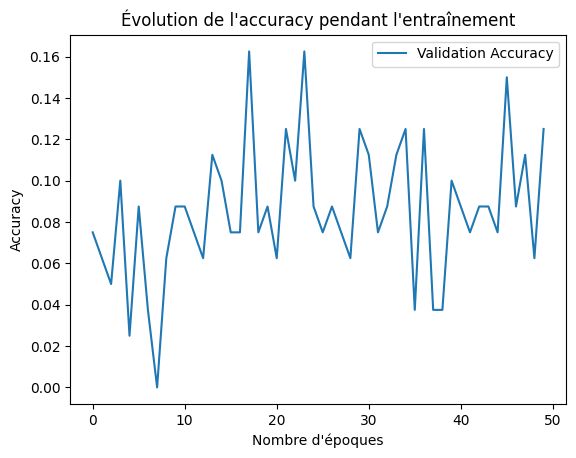

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.metrics.distance import edit_distance

# Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        # Validation Accuracy
        validation_data = next(self.validation_data)
        predictions = self.model.predict(validation_data[0])
        decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
        ground_truth = validation_data[1]

        accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
        print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
        self.accuracies.append(accuracy)

# Fonction pour calculer l'accuracy lettre par lettre
def compute_accuracy_letter_by_letter(preds, truths):
    total_letters = 0
    correct_letters = 0

    for pred, truth in zip(preds, truths):
        for p, t in zip(pred, truth):
            total_letters += 1
            if p == t:
                correct_letters += 1

    accuracy = correct_letters / total_letters if total_letters > 0 else 0
    return accuracy

# Chargement des données (assurez-vous de définir la fonction mappable_function)
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Division des données en ensembles d'entraînement et de test
train_size = 450
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Création des lots (batches) de données
train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# Préchargement des données
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)



# Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
model.compile(optimizer='adam', loss=CTCLoss)  # Utilisation de votre fonction de perte personnalisée

accuracy_callback = AccuracyCallback(validation_data=test_data)

history = model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[accuracy_callback])

# Plotter les courbes d'accuracy
plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'accuracy pendant l\'entraînement')
plt.legend()
plt.show()
